<a href="https://colab.research.google.com/github/Krizzhiv/Biodiversity_Assessment_from_eDNA/blob/main/Biodiversity_asessment_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# CELL 1: ENVIRONMENT SETUP
# ==============================================================================
# This cell installs all necessary external tools and Python libraries.

# --- Install Command-Line Tools ---
print("Installing VSEARCH...")
!apt-get -qq install vsearch > /dev/null
print("VSEARCH installed.")

# --- Install Python Libraries ---
print("Installing tensorflow...")
!pip install tensorflow > /dev/null
print("tensorflow installed.")

print("Installing biopython...")
!pip install biopython > /dev/null
print("biopython installed.")

# <<< ADDED HDBSCAN AND UMAP INSTALLATION HERE >>>
print("Installing HDBSCAN & UMAP...")
!pip install hdbscan umap-learn > /dev/null
print("HDBSCAN & UMAP installed.")


print("\nEnvironment setup complete.")

Installing VSEARCH...
VSEARCH installed.
Installing tensorflow...


The system cannot find the path specified.


tensorflow installed.
Installing biopython...


The system cannot find the path specified.


biopython installed.
Installing HDBSCAN & UMAP...


The system cannot find the path specified.


HDBSCAN & UMAP installed.

Environment setup complete.


The system cannot find the path specified.


In [2]:
# ==============================================================================
# CELL 2: IMPORT LIBRARIES
# ==============================================================================
# This cell imports all the Python libraries we will use in our pipeline.

import subprocess
import pandas as pd
import numpy as np
from Bio.Blast import NCBIWWW, NCBIXML
from itertools import product
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import hdbscan
import umap
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


print("Libraries imported successfully.")

c:\Users\krish\TECH STACK\Projects\Taxonomy prediction from eDNA\Git\Biodiversity_Assessment_from_eDNA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


In [3]:
# ==============================================================================
# CELL 3: PIPELINE FUNCTION DEFINITIONS
# ==============================================================================
# This cell contains all the core functions for the eDNA analysis pipeline.

# ------------------------------------------------------------------------------
# FUNCTION 1: Load and Parse the FASTQ file
# ------------------------------------------------------------------------------
def load_and_parse_fastq(filename):
    """
    Reads a FASTQ file and extracts the DNA sequences.

    Args:
        filename (str): The path to the FASTQ file.

    Returns:
        list: A list of DNA sequence strings.
    """
    print(f"-> Loading and parsing '{filename}'...")
    dna_sequences = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for i in range(0, len(lines), 4):
            sequence = lines[i+1].strip()
            dna_sequences.append(sequence)
    print(f"   Done. Extracted {len(dna_sequences)} sequences.")
    return dna_sequences

# ------------------------------------------------------------------------------
# FUNCTION 2: Run the VSEARCH Clustering
# ------------------------------------------------------------------------------
def run_vsearch_clustering(sequences, identity_threshold=0.97):
    """
    Takes a list of DNA sequences and clusters them using VSEARCH.

    Args:
        sequences (list): A list of DNA sequence strings.
        identity_threshold (float): The similarity threshold for clustering (0.0 to 1.0).

    Returns:
        tuple: A tuple containing the filenames of the centroid and cluster map files.
               (e.g., ('centroids.fasta', 'clusters.uc'))
    """
    # Define filenames
    fasta_input_file = "sequences_to_cluster.fasta"
    centroid_file = "centroids.fasta"
    cluster_map_file = "clusters.uc"

    # 1. Write sequences to a FASTA file for VSEARCH
    print(f"-> Writing {len(sequences)} sequences to '{fasta_input_file}'...")
    with open(fasta_input_file, 'w') as f:
        for i, seq in enumerate(sequences):
            f.write(f">read_{i}\n")
            f.write(f"{seq}\n")

    # 2. Construct and run the VSEARCH command
    print(f"-> Starting clustering with a {identity_threshold*100}% identity threshold...")
    command = [
        "./vsearch",
        "--cluster_fast", fasta_input_file,
        "--id", str(identity_threshold),
        "--centroids", centroid_file,
        "--uc", cluster_map_file
    ]
    # We use subprocess.run to execute the command
    subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # 3. Count the number of clusters found
    num_clusters = 0
    with open(centroid_file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                num_clusters += 1
        print(f"   Done. Found {num_clusters} unique clusters (OTUs).")
        return centroid_file, cluster_map_file

# ------------------------------------------------------------------------------
# FUNCTION 3: Calculate the Abundance of Each Cluster
# ------------------------------------------------------------------------------
def calculate_abundance(cluster_map_file):
    """
    Parses the VSEARCH cluster map file (.uc) to calculate OTU abundance.

    Args:
        cluster_map_file (str): The path to the .uc file from VSEARCH.

    Returns:
        pandas.DataFrame: A DataFrame with 'cluster_num' and 'abundance', sorted.
    """
    print(f"-> Calculating abundance from '{cluster_map_file}'...")
    cluster_data = []
    with open(cluster_map_file, 'r') as f:
        for line in f:
            if line.startswith('H') or line.startswith('C'):
                parts = line.strip().split('\t')
                cluster_num = int(parts[1])
                cluster_data.append([cluster_num])

    df_clusters = pd.DataFrame(cluster_data, columns=['cluster_num'])
    df_abundance = df_clusters['cluster_num'].value_counts().reset_index()
    df_abundance.columns = ['cluster_num', 'abundance']
    df_abundance = df_abundance.sort_values(by='abundance', ascending=False)
    print("   Done.")
    return df_abundance

# ------------------------------------------------------------------------------
# FUNCTION 4: Load Centroid Sequences into a Dictionary
# ------------------------------------------------------------------------------
def load_centroids(centroid_file):
    """
    Loads the representative sequences from the centroids FASTA file.

    Args:
        centroid_file (str): The path to the centroids FASTA file.

    Returns:
        dict: A dictionary mapping read_id (str) to DNA sequence (str).
    """
    print(f"-> Loading representative sequences from '{centroid_file}'...")
    centroid_sequences = {}
    with open(centroid_file, 'r') as f:
        current_read_id = ""
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_read_id = line[1:]
                centroid_sequences[current_read_id] = ""
            else:
                centroid_sequences[current_read_id] += line
    print(f"   Done. Loaded {len(centroid_sequences)} sequences.")
    return centroid_sequences
# ------------------------------------------------------------------------------
# FUNCTION 5: Perform a BLAST Search for a single sequence
# ------------------------------------------------------------------------------
def get_blast_result(sequence):
    """
    Performs an online BLAST search for a given DNA sequence and returns the top hit.

    Args:
        sequence (str): The DNA sequence to search for.

    Returns:
        str: A formatted string describing the top hit, or a "Not Found" message.
    """
    # NCBIWWW.qblast can sometimes be slow or fail. A try/except block is good practice.
    try:
        result_handle = NCBIWWW.qblast("blastn", "nt", sequence)
        blast_record = NCBIXML.read(result_handle)

        if len(blast_record.alignments) > 0:
            top_alignment = blast_record.alignments[0]
            species_name = top_alignment.title.split(',')[0] # Get a cleaner name
            identity = (top_alignment.hsps[0].identities / top_alignment.hsps[0].align_length) * 100

            return f"{species_name} ({identity:.2f}% identity)"
        else:
            return "NO SIGNIFICANT MATCH FOUND (Novel Taxon)"

    except Exception as e:
        # If the BLAST search fails for any reason (e.g., internet issue)
        return f"BLAST search failed: {e}"


# ------------------------------------------------------------------------------
# FUNCTION 6: Calculate Biodiversity Metrics
# ------------------------------------------------------------------------------
def calculate_diversity_metrics(df_abundance):
  """Calculate Shannon and Simpson diversity indices"""
  total_reads = df_abundance['abundance'].sum()
  proportions = df_abundance['abundance'] / total_reads

  # Shannon Index
  shannon = -sum(p * np.log(p) for p in proportions if p > 0)

  # Simpson Index
  simpson = sum(p**2 for p in proportions)

  return {
      'shannon_index': shannon,
      'simpson_index': 1 - simpson,
      'total_otus': len(df_abundance),
      'effective_species': np.exp(shannon)  # Hill number
  }


# ------------------------------------------------------------------------------
# FUNCTION 7: Analyze Cluster Distribution
# ------------------------------------------------------------------------------
def analyze_cluster_distribution(df_abundance, threshold=0.01):
    """Identify rare vs dominant taxa"""
    total = df_abundance['abundance'].sum()
    df_abundance['relative_abundance'] = df_abundance['abundance'] / total

    df_abundance['category'] = df_abundance['relative_abundance'].apply(
        lambda x: 'Dominant' if x > 0.05 else 'Common' if x > threshold else 'Rare'
    )

    return df_abundance

# ------------------------------------------------------------------------------
# FUNCTION 8: Generate K-mer Vocabulary
# ------------------------------------------------------------------------------
def generate_kmer_vocabulary(k=6):
    """Generate all possible k-mers for DNA"""
    bases = ['A', 'T', 'G', 'C']
    return [''.join(p) for p in product(bases, repeat=k)]


# ------------------------------------------------------------------------------
# FUNCTION 9: Convert Sequence to K-mer Vector
# ------------------------------------------------------------------------------
def sequence_to_kmer_vector(sequence, k=6, stride=1):
    """Convert DNA sequence to k-mer frequency vector"""
    kmer_vocab = generate_kmer_vocabulary(k)
    kmer_to_idx = {kmer: idx for idx, kmer in enumerate(kmer_vocab)}

    # Initialize frequency vector
    vector = np.zeros(len(kmer_vocab))

    # Count k-mers with overlapping window
    for i in range(0, len(sequence) - k + 1, stride):
        kmer = sequence[i:i+k]
        if kmer in kmer_to_idx:
            vector[kmer_to_idx[kmer]] += 1

    # Normalize by sequence length
    if vector.sum() > 0:
        vector = vector / vector.sum()

    return vector


# ------------------------------------------------------------------------------
# CLASS 10: Variational Autoencoder (VAE) Model
# ------------------------------------------------------------------------------
class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim=32):
        super(VAE, self).__init__()


        self.input_dim = input_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu')
        ])

        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

        # Decoder
        self.decoder = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(latent_dim,)),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim)
        ])

    def encode(self, x):
        h = self.encoder(x)
        return self.z_mean(h), self.z_log_var(h)

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * 0.5) + z_mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)

        # Calculate loss
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(x, reconstructed)
        )

        reconstruction_loss *= self.input_dim

        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed


# ------------------------------------------------------------------------------
# FUNCTION 11: Calculate Group Coherence
# ------------------------------------------------------------------------------
def calculate_group_coherence(group_embeddings):
    """Calculate how tightly clustered a group is"""
    if len(group_embeddings) < 2:
        return 1.0
    distances = pdist(group_embeddings, metric='cosine')
    return 1.0 - distances.mean() if len(distances) > 0 else 1.0


# ------------------------------------------------------------------------------
# FUNCTION 12: Assess Novelty Score
# ------------------------------------------------------------------------------
def assess_novelty_score(embedding, all_embeddings, k=10):
    """Calculate novelty based on distance to nearest neighbors"""
    # Ensure n_neighbors is not greater than the number of samples
    n_samples = all_embeddings.shape[0]
    if k >= n_samples:
        k = n_samples - 1

    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(all_embeddings)
    distances, _ = nn.kneighbors([embedding])
    novelty = distances[0].mean()
    return novelty


# ------------------------------------------------------------------------------
# FUNCTION 13: Generate Final Report
# ------------------------------------------------------------------------------
def generate_final_report():
    print("\n" + "="*70)
    print(" "*20 + "AI-DRIVEN eDNA BIODIVERSITY REPORT")
    print("="*70)

    # 1. Overall Statistics
    print("\n📊 OVERALL STATISTICS")
    print(f"  • Total sequences analyzed: {len(sequences)}")
    print(f"  • Unique OTUs discovered: {len(df_abundance)}")
    print(f"  • Shannon Diversity Index: {diversity_stats['shannon_index']:.3f}")
    print(f"  • Effective Number of Species: {diversity_stats['effective_species']:.1f}")

    # 2. Ecological Group Summary
    print("\n🌊 ECOLOGICAL GROUPS (AI-Discovered)")
    print(f"  • Total ecological groups: {n_clusters}")
    print(f"  • Unclustered OTUs (potential novel): {n_noise}")

    if len(df_groups) > 0:
        print("\n  Top 5 Ecological Groups by Abundance:")
        for _, group in df_groups.nlargest(5, 'total_abundance').iterrows():
            print(f"    - Group {group['group_id']}: {group['num_otus']} OTUs, "
                  f"{group['total_abundance']} reads, {group['classification']}")

    # 3. Novel Taxa Discovery
    print("\n🔬 NOVEL TAXA CANDIDATES")
    if novel_candidates:
        print(f"  • High-confidence novel taxa: {len(novel_candidates)}")
        for candidate in novel_candidates[:3]:
            print(f"    - OTU {candidate['otu_id']}: "
                  f"Novelty score {candidate['novelty_score']:.3f}, "
                  f"Abundance: {candidate['abundance']}")
    else:
        print("  • No high-confidence novel taxa detected")

    # 4. Abundance Distribution
    print("\n📈 ABUNDANCE DISTRIBUTION")
    categories = df_abundance['category'].value_counts()
    for cat, count in categories.items():
        print(f"  • {cat} taxa: {count} OTUs")

    # 5. Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Abundance distribution
    axes[0, 0].hist(np.log10(df_abundance['abundance'] + 1), bins=30, edgecolor='black')
    axes[0, 0].set_xlabel('Log10(Abundance + 1)')
    axes[0, 0].set_ylabel('Number of OTUs')
    axes[0, 0].set_title('OTU Abundance Distribution')

    # Plot 2: UMAP visualization
    scatter = axes[0, 1].scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                                 c=cluster_labels, cmap='tab20', alpha=0.6)
    axes[0, 1].set_xlabel('UMAP 1')
    axes[0, 1].set_ylabel('UMAP 2')
    axes[0, 1].set_title('Ecological Groups (AI Clustering)')

    # Plot 3: Group sizes
    if len(df_groups) > 0:
        group_sizes = df_groups['total_abundance'].values[:10]
        group_ids = [f"G{g}" for g in df_groups['group_id'].values[:10]]
        axes[1, 0].bar(range(len(group_sizes)), group_sizes)
        axes[1, 0].set_xticks(range(len(group_ids)))
        axes[1, 0].set_xticklabels(group_ids)
        axes[1, 0].set_xlabel('Ecological Group')
        axes[1, 0].set_ylabel('Total Abundance')
        axes[1, 0].set_title('Top 10 Ecological Groups')

    # Plot 4: Novelty distribution
    all_novelty_scores = [assess_novelty_score(e, embeddings) for e in embeddings[:100]]
    axes[1, 1].hist(all_novelty_scores, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(np.percentile(all_novelty_scores, 90), color='red',
                       linestyle='--', label='Novel threshold')
    axes[1, 1].set_xlabel('Novelty Score')
    axes[1, 1].set_ylabel('Number of OTUs')
    axes[1, 1].set_title('Novelty Score Distribution')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("Report generation complete. Results ready for interpretation.")
    print("="*70)

In [4]:
# ==============================================================================
# CELL 4: PIPELINE SCRIPT WITH TOP-N TAXONOMY ANALYSIS
# ==============================================================================

# --- Configuration ---
input_file = "data/sample.fastq"
num_top_otus_to_identify = 10

# --- 1. Run the Core Pipeline ---
print("--- [Step 1/3] Starting Core eDNA Analysis ---")
sequences = load_and_parse_fastq(input_file)
centroid_filepath, cluster_map_filepath = run_vsearch_clustering(sequences)
df_abundance = calculate_abundance(cluster_map_filepath)
centroid_sequences = load_centroids(centroid_filepath)
print("--- Core Analysis Complete ---\n")

# --- 2. Get Centroid IDs for the Top N OTUs ---
print(f"--- [Step 2/3] Preparing to Identify Top {num_top_otus_to_identify} OTUs ---")
# We need to find the representative read ID for each of our top clusters
# First, let's parse the cluster map (.uc) again to map cluster_num to centroid_id
cluster_to_centroid = {}
with open(cluster_map_filepath, 'r') as f:
    for line in f:
        if line.startswith('C'): # Centroid lines define the mapping
            parts = line.strip().split('\t')
            cluster_num = int(parts[1])
            centroid_id = parts[8]
            cluster_to_centroid[cluster_num] = centroid_id

# Add a new column to our abundance table with the centroid ID
df_abundance['centroid_id'] = df_abundance['cluster_num'].map(cluster_to_centroid)
print("--- Preparation Complete ---\n")

# Run enhanced analysis
df_abundance = analyze_cluster_distribution(df_abundance)
diversity_stats = calculate_diversity_metrics(df_abundance)

print(f"Shannon Diversity: {diversity_stats['shannon_index']:.3f}")
print(f"Effective Number of Species: {diversity_stats['effective_species']:.1f}")

--- [Step 1/3] Starting Core eDNA Analysis ---
-> Loading and parsing 'data/sample.fastq'...
   Done. Extracted 10000 sequences.
-> Writing 10000 sequences to 'sequences_to_cluster.fasta'...
-> Starting clustering with a 97.0% identity threshold...
   Done. Found 604 unique clusters (OTUs).
-> Calculating abundance from 'clusters.uc'...
   Done.
-> Loading representative sequences from 'centroids.fasta'...
   Done. Loaded 604 sequences.
--- Core Analysis Complete ---

--- [Step 2/3] Preparing to Identify Top 10 OTUs ---
--- Preparation Complete ---

Shannon Diversity: 3.076
Effective Number of Species: 21.7


In [5]:
# ==============================================================================
# CELL 5: K-MER TOKENIZATION FOR DEEP LEARNING
# ==============================================================================

# Convert all centroid sequences to k-mer vectors
print("Converting sequences to k-mer vectors...")
kmer_matrix = []
sequence_ids = []

for seq_id, sequence in centroid_sequences.items():
    kmer_vector = sequence_to_kmer_vector(sequence, k=6, stride=2)
    kmer_matrix.append(kmer_vector)
    sequence_ids.append(seq_id)

X = np.array(kmer_matrix)
print(f"Created matrix of shape: {X.shape}")
print(f"  - {X.shape[0]} OTUs")
print(f"  - {X.shape[1]} k-mer features")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Converting sequences to k-mer vectors...
Created matrix of shape: (604, 4096)
  - 604 OTUs
  - 4096 k-mer features


In [6]:
# ==============================================================================
# CELL 6: VARIATIONAL AUTOENCODER FOR REPRESENTATION LEARNING
# ==============================================================================

# Create and train VAE
print("Building VAE model...")
vae = VAE(input_dim=X_scaled.shape[1], latent_dim=32)
vae.compile(optimizer='adam')

# Train the model
print("Training VAE on your deep-sea eDNA data...")
history = vae.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.1
)

# Extract embeddings
z_mean, _ = vae.encode(X_scaled)
embeddings = z_mean.numpy()
print(f"Generated embeddings with shape: {embeddings.shape}")

Building VAE model...


c:\Users\krish\TECH STACK\Projects\Taxonomy prediction from eDNA\Git\Biodiversity_Assessment_from_eDNA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training VAE on your deep-sea eDNA data...
Generated embeddings with shape: (604, 32)


In [7]:
# ==============================================================================
# CELL 7: DISCOVER ECOLOGICAL GROUPS VIA HDBSCAN
# ==============================================================================

# First, reduce dimensions for visualization
print("Reducing dimensions for visualization...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Perform hierarchical clustering
print("Discovering ecological groups...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3,
    cluster_selection_epsilon=0.5
)
cluster_labels = clusterer.fit_predict(embeddings)

# Analyze results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Found {n_clusters} ecological groups")
print(f"Unclustered OTUs (potential novel taxa): {n_noise}")

# Create ecological group mapping
ecological_groups = {}
for i, label in enumerate(cluster_labels):
    seq_id = sequence_ids[i]
    ecological_groups[seq_id] = label

# Add to abundance dataframe
df_abundance['ecological_group'] = df_abundance['centroid_id'].map(ecological_groups)

Reducing dimensions for visualization...


c:\Users\krish\TECH STACK\Projects\Taxonomy prediction from eDNA\Git\Biodiversity_Assessment_from_eDNA\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Discovering ecological groups...
Found 4 ecological groups
Unclustered OTUs (potential novel taxa): 119


c:\Users\krish\TECH STACK\Projects\Taxonomy prediction from eDNA\Git\Biodiversity_Assessment_from_eDNA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krish\TECH STACK\Projects\Taxonomy prediction from eDNA\Git\Biodiversity_Assessment_from_eDNA\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# ==============================================================================
# CELL 8: AI-DRIVEN TAXONOMY AND NOVEL TAXA DISCOVERY (Corrected)
# ==============================================================================

# === PASS 1: GATHER METRICS FOR ALL GROUPS ===
# In this pass, we just collect the data without trying to classify it yet.
print("--- [Pass 1/2] Analyzing discovered groups... ---")
group_analysis = []
for group_id in df_abundance['ecological_group'].unique():
    if group_id == -1:
        continue

    group_otus = df_abundance[df_abundance['ecological_group'] == group_id]
    group_abundance = group_otus['abundance'].sum()
    group_size = len(group_otus)

    group_indices = [sequence_ids.index(otu_id) for otu_id in group_otus['centroid_id']]
    group_embeddings = embeddings[group_indices]

    coherence = calculate_group_coherence(group_embeddings)
    mean_embedding = group_embeddings.mean(axis=0)
    novelty = assess_novelty_score(mean_embedding, embeddings)

    group_analysis.append({
        'group_id': group_id,
        'num_otus': group_size,
        'total_abundance': group_abundance,
        'coherence_score': coherence,
        'novelty_score': novelty
    })

df_groups = pd.DataFrame(group_analysis)
print(f"   Done. Found {len(df_groups)} groups to analyze.")

# === PASS 2: CLASSIFY GROUPS BASED ON COMPLETE DATA ===
# Now that we have all novelty scores, we can safely calculate percentiles.
print("--- [Pass 2/2] Classifying groups and identifying novel candidates... ---")
if not df_groups.empty:
    novelty_threshold = df_groups['novelty_score'].quantile(0.75)
    df_groups['classification'] = df_groups['novelty_score'].apply(
        lambda x: 'Novel Group' if x > novelty_threshold else 'Known Pattern'
    )

# For unclustered OTUs (group -1), assess individually
unclustered = df_abundance[df_abundance['ecological_group'] == -1]
novel_candidates = []

all_novelty_scores = [assess_novelty_score(e, embeddings) for e in embeddings]
novelty_candidate_threshold = np.percentile(all_novelty_scores, 90)

for _, otu in unclustered.iterrows():
    idx = sequence_ids.index(otu['centroid_id'])
    novelty = all_novelty_scores[idx]

    if novelty > novelty_candidate_threshold:
        novel_candidates.append({
            'otu_id': otu['cluster_num'],
            'abundance': otu['abundance'],
            'novelty_score': novelty,
            'status': 'High Priority Novel Taxon Candidate'
        })
print(f"   Done. Identified {len(novel_candidates)} high-priority novel candidates.")

# === SELECTIVE BLAST VALIDATION ===
print("\n=== Selective Validation with BLAST ===")
print("(Validating top 3 groups and top 3 novel candidates)")

if not df_groups.empty:
    top_groups = df_groups.nlargest(3, 'total_abundance')
    for _, group in top_groups.iterrows():
        group_otus = df_abundance[df_abundance['ecological_group'] == group['group_id']]
        representative_otu = group_otus.nlargest(1, 'abundance').iloc[0]
        representative_id = representative_otu['centroid_id']
        sequence = centroid_sequences[representative_id]

        print(f"\nGroup #{group['group_id']} (Abundance: {group['total_abundance']}):")
        blast_result = get_blast_result(sequence[:500])
        print(f"  Representative (OTU #{representative_otu['cluster_num']}): {blast_result}")
        print(f"  AI Classification: {group['classification']}")
else:
    print("\nNo groups were found to validate.")

if novel_candidates:
    top_novel = sorted(novel_candidates, key=lambda x: x['novelty_score'], reverse=True)[:3]
    for candidate in top_novel:
        otu_id_to_find = df_abundance[df_abundance['cluster_num'] == candidate['otu_id']].iloc[0]['centroid_id']
        sequence = centroid_sequences[otu_id_to_find]

        print(f"\nHigh Priority Candidate (OTU #{candidate['otu_id']}):")
        blast_result = get_blast_result(sequence[:500])
        print(f"  Novelty Score: {candidate['novelty_score']:.4f}")
        print(f"  BLAST Result: {blast_result}")
else:
    print("\nNo high-priority novel candidates found.")

--- [Pass 1/2] Analyzing discovered groups... ---
   Done. Found 4 groups to analyze.
--- [Pass 2/2] Classifying groups and identifying novel candidates... ---
   Done. Identified 58 high-priority novel candidates.

=== Selective Validation with BLAST ===
(Validating top 3 groups and top 3 novel candidates)

Group #0 (Abundance: 4731):
  Representative (OTU #3): gi|1912443983|gb|MW053366.1| Foraminifera sp. clone EF11.17 small subunit ribosomal RNA gene (97.92% identity)
  AI Classification: Known Pattern

Group #3 (Abundance: 2874):
  Representative (OTU #2): gi|2859743977|gb|PQ628057.1| Ammonia sp. TKaushik-2024a voucher Ammonia_nigami_SP316_SSU small subunit ribosomal RNA gene (98.66% identity)
  AI Classification: Known Pattern

Group #1 (Abundance: 2109):
  Representative (OTU #5): gi|2165708664|gb|OL873238.1| Monothalamids sp. isolate 18564 clone 23 small subunit ribosomal RNA gene (100.00% identity)
  AI Classification: Novel Group

High Priority Candidate (OTU #152):
  Novelty 


                    AI-DRIVEN eDNA BIODIVERSITY REPORT

📊 OVERALL STATISTICS
  • Total sequences analyzed: 10000
  • Unique OTUs discovered: 604
  • Shannon Diversity Index: 3.076
  • Effective Number of Species: 21.7

🌊 ECOLOGICAL GROUPS (AI-Discovered)
  • Total ecological groups: 4
  • Unclustered OTUs (potential novel): 119

  Top 5 Ecological Groups by Abundance:
    - Group 0: 127 OTUs, 4731 reads, Known Pattern
    - Group 3: 319 OTUs, 2874 reads, Known Pattern
    - Group 1: 23 OTUs, 2109 reads, Novel Group
    - Group 2: 16 OTUs, 16 reads, Known Pattern

🔬 NOVEL TAXA CANDIDATES
  • High-confidence novel taxa: 58
    - OTU 65: Novelty score 5.539, Abundance: 31
    - OTU 35: Novelty score 6.976, Abundance: 13
    - OTU 79: Novelty score 4.396, Abundance: 13

📈 ABUNDANCE DISTRIBUTION
  • Rare taxa: 592 OTUs
  • Common taxa: 8 OTUs
  • Dominant taxa: 4 OTUs


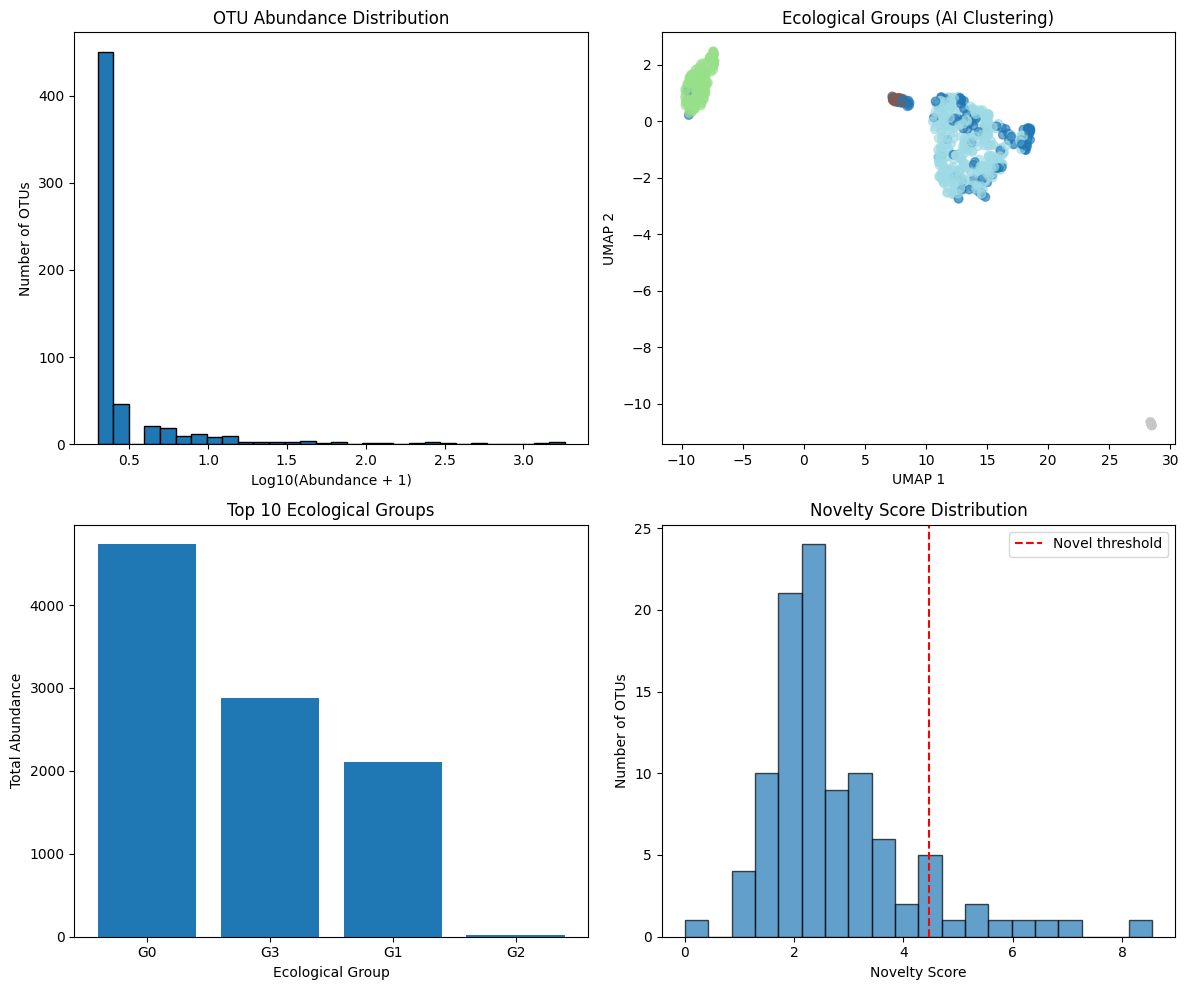


Report generation complete. Results ready for interpretation.


In [9]:
# ==============================================================================
# CELL 9: GENERATE FINAL BIODIVERSITY REPORT
# ==============================================================================

# Generate the report
generate_final_report()